In [1]:
import numpy as np
import pandas as pd

/kaggle/input/offshoreforecasting/wt_decomposition_results.csv
/kaggle/input/offshoreforecasting/emdresults.csv
/kaggle/input/offshoreforecasting/tvfemdresults_TenneT.csv
/kaggle/input/offshoreforecasting/emdfujian.csv
/kaggle/input/offshoreforecasting/imfreconstruction_TenneT.csv
/kaggle/input/offshoreforecasting/tvfemdresults_fujian.csv
/kaggle/input/offshoreforecasting/wt_decomposition_fujian.csv
/kaggle/input/offshoreforecasting/time_series_15min_singleindex_filtered.csv
/kaggle/input/offshoreforecasting/res_new.csv
/kaggle/input/offshoreforecasting/time_series_15min_cleaned.csv
/kaggle/input/offshoreforecasting/vmd_reconstruction.csv
/kaggle/input/offshoreforecasting/vmd_decomposition_fujian.csv


# **1. Data clean (TenneT)**

In [2]:
# 1. load data
df = pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/section 4/time_series_15min_singleindex_filtered.csv')

# 2. fill in NaN values
df['DE_tennet_wind_offshore_generation_actual'] = df['DE_tennet_wind_offshore_generation_actual'].fillna(method='ffill')

# 4.
missing_count = df['DE_tennet_wind_offshore_generation_actual'].isnull().sum()
print(f"NaN counts：{missing_count}")

# 5. 保存清洗后数据
df.to_csv('time_series_15min_cleaned.csv', index=False)
print("Data clean finished: time_series_15min_cleaned.csv")

NaN counts：0
Data clean finished: time_series_15min_cleaned.csv


/tmp/ipykernel_47/3420910873.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['DE_tennet_wind_offshore_generation_actual'] = df['DE_tennet_wind_offshore_generation_actual'].fillna(method='ffill')


In [5]:
#Only for fujian dataset
df = pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/5.1/input/res_new.csv')
a=df["Power"]
a = np.array(a.values)

# **2. Seasonal test**

In [3]:
!pip install pymannkendall

In [2]:
import pymannkendall as mk
df = pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/section 4/time_series_15min_cleaned.csv')

In [3]:
a=df["DE_tennet_wind_offshore_generation_actual"]
a = np.array(a.values)
result = mk.original_test(a)

In [6]:
result

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-56.153364333174, Tau=-0.2308353719700962, s=-79854509.0, var_s=2022308064437.0, slope=-0.07854835606773065, intercept=3263.4737048247594)

# **3. Visualization**

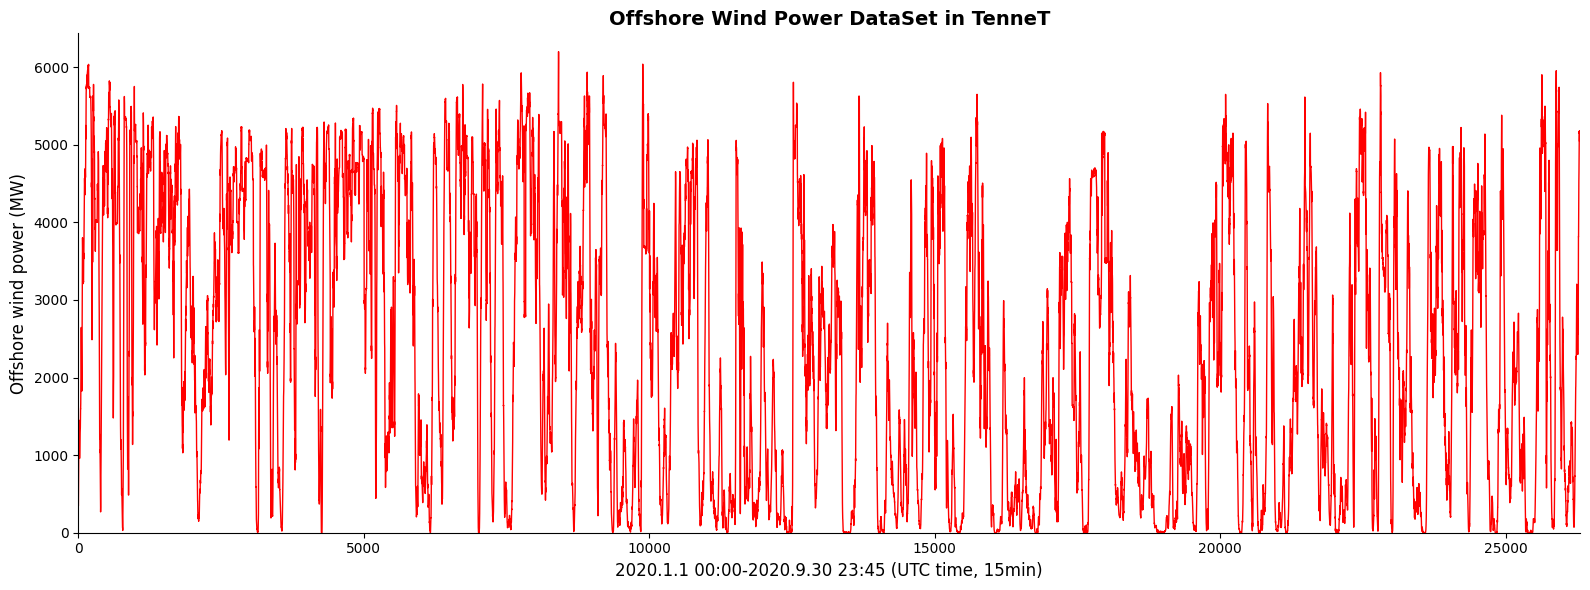

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(a, color='red', linewidth=1)

plt.title('Offshore Wind Power DataSet in TenneT', fontsize=14, fontweight='bold')
plt.ylabel('Offshore wind power (MW)', fontsize=12)
plt.xlabel('2020.1.1 00:00-2020.9.30 23:45 (UTC time, 15min)', fontsize=12)

plt.ylim(0, 6435.69)
plt.xlim(0, 26304)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig("fig2tennet.png",dpi=400)
plt.show()

# **4.Decomposition**

# 4.1. TVFEMD decomposition

In [5]:
!pip install pytvfemd pyinstrument line_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.5/146.5 kB 7.5 MB/s eta 0:00:00


In [7]:
from pytvfemd import tvfemd
#from line_profiler import LineProfiler

imf=tvfemd(a, bsp_order=28)#tennet
#imf=tvfemd(a[:,0], bsp_order=28)#fujian

#lp = LineProfiler()
#lp.add_function(tvfemd)

#lp_wrapper = lp(tvfemd)
#lp_wrapper(a)
#lp.print_stats()

In [8]:
imf.shape

(11519, 14)

In [10]:
imf.shape
df = pd.DataFrame(imf, columns=["IMF1", "IMF2", "IMF3", "IMF4", "IMF5", "IMF6", "IMF7", 
                               "IMF8", "IMF9", "IMF10", "IMF11", "IMF12", "IMF13", "residual"])#TenneT 14, fujian 13
df.to_csv("tvfemdresults_fujian.csv", index=False)#tvfemdresults_TenneT,tvfemdresults_fujian

In [12]:
de=pd.read_csv('tvfemdresults_TenneT.csv')

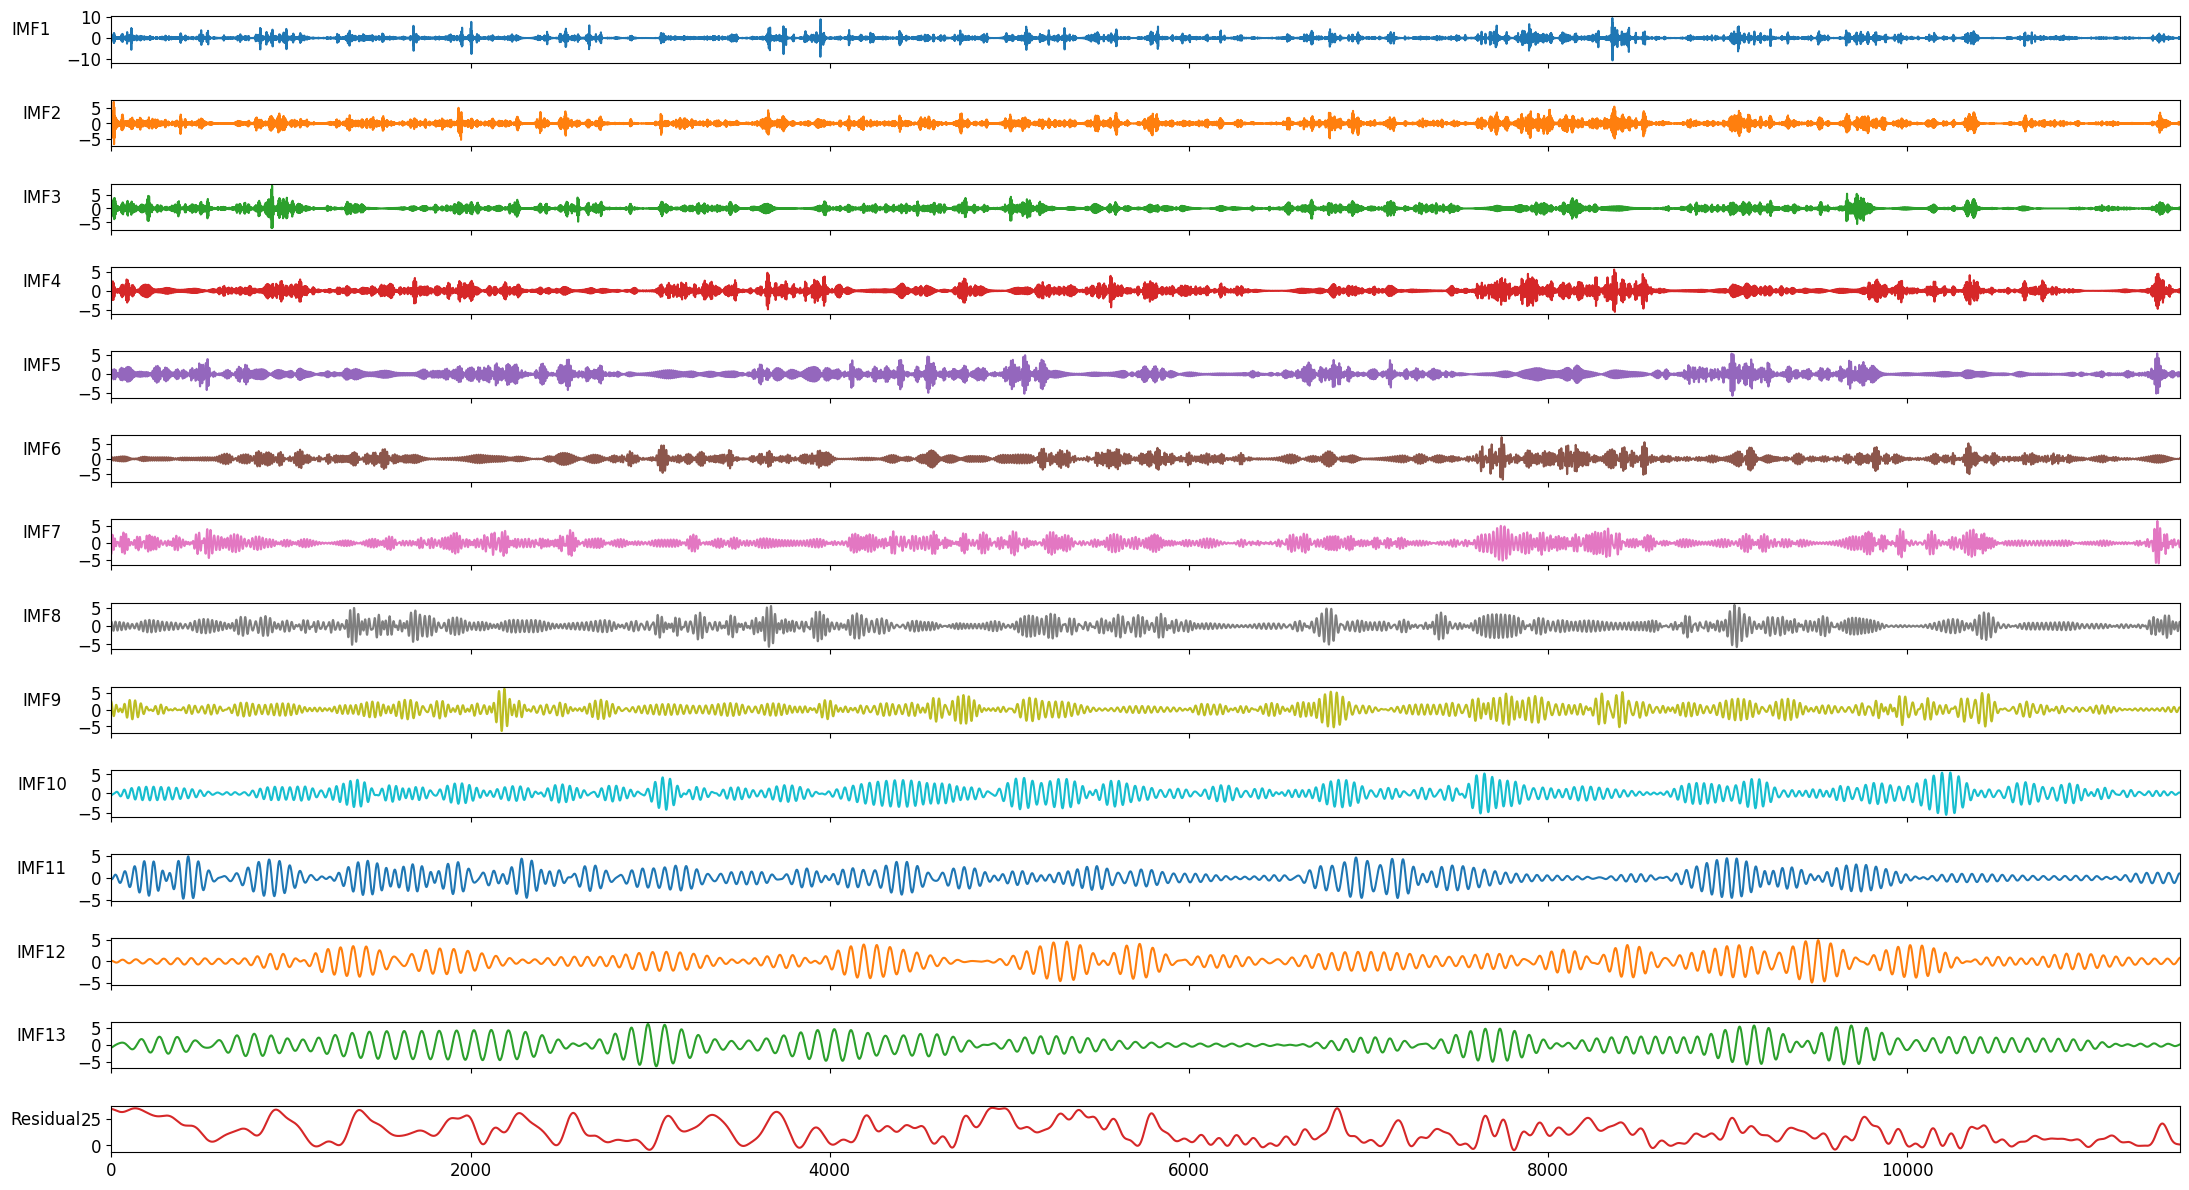

In [7]:
imf=de.iloc[:,:].plot(subplots = True,legend=False,figsize=(22,12),fontsize=12)
for i in range(13):#fujian 13, tennet 14
    imf[i].set_ylabel('IMF{}'.format(i+1), labelpad=25.5,rotation='horizontal',fontsize=12)
    imf[-1].set_ylabel('Residual',labelpad=25.5,rotation='horizontal',fontsize=12)
plt.xlim(0,11519)
plt.tight_layout()
plt.subplots_adjust(hspace=0.8)
plt.savefig('tvfemd_fujian.png',dpi=400)
plt.show()

# 4.2 VMD results

In [6]:
!pip install vmdpy pyswarm antropy

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=94eadc3af0bc92ad44d785e1b18a3b8e9b1685538857b26e175e8a246143eb7f
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [7]:
import numpy as np
from vmdpy import VMD
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import antropy as ant  # pip install antropy
from line_profiler import LineProfiler
import random

def set_seed(seed=42):

    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

class VMD_PSO_Optimizer:

    def __init__(self, signal, tau=0, DC=0, init=1, tol=1e-7, seed=42):
        self.signal = signal
        self.tau = tau
        self.DC = DC
        self.init = init
        self.tol = tol
        self.eval_count = 0
        self.seed = seed

        set_seed(self.seed)

        self.profiler = LineProfiler()
        
    def fitness_function(self, params):

        K = int(np.round(params[0]))
        alpha = np.round(params[1] / 500) * 500
        
        K = max(2, min(K, 15))
        
        try:
            # VMD
            u, u_hat, omega = VMD(
                self.signal, 
                alpha=alpha, 
                tau=self.tau, 
                K=K, 
                DC=self.DC, 
                init=self.init, 
                tol=self.tol
            )

            reconstructed = np.sum(u, axis=0)
            
            min_len = min(len(self.signal), len(reconstructed))
            signal_aligned = self.signal[:min_len]
            reconstructed_aligned = reconstructed[:min_len]
        
            # fitness calculation
            fitness = mean_squared_error(signal_aligned, reconstructed_aligned)
            
            self.eval_count += 1
            if self.eval_count % 10 == 0:
                print(f"评估 {self.eval_count}: K={K}, alpha={alpha:.0f}, fitness={fitness:.6f}")
            
            return fitness
            
        except Exception as e:
            print(f"分解失败: K={K}, alpha={alpha}, Error: {e}")
            return 1e10
    
    def calculate_correlation_penalty(self, modes):

        K = modes.shape[0]
        correlations = []
        
        for i in range(K):
            for j in range(i+1, K):
                corr, _ = pearsonr(modes[i], modes[j])
                correlations.append(abs(corr))
        
        return np.mean(correlations) if correlations else 0
    
    def optimize(self, K_range=(2, 12), alpha_range=(500, 5000), 
                 swarmsize=20, maxiter=50):

        set_seed(self.seed)
        
        print("="*60)
        print(f"开始优化 | K范围: {K_range} | Alpha范围: {alpha_range}")
        print(f"随机种子: {self.seed}")
        print("="*60)
        
        lb = [K_range[0], alpha_range[0]]
        ub = [K_range[1], alpha_range[1]]
        
        best_params, best_fitness = pso(
            self.fitness_function,
            lb, ub,
            swarmsize=swarmsize,
            maxiter=maxiter,
            omega=0.5,
            phip=1.5,
            phig=1.5,
            debug=True
        )
        
        best_K = int(np.round(best_params[0]))
        best_alpha = np.round(best_params[1] / 500) * 500
        
        print("="*60)
        print(f"最优K: {best_K} | 最优Alpha: {best_alpha:.0f}")
        print(f"最优适应度: {best_fitness:.6f}")
        print("="*60)
        
        return [best_K, best_alpha], best_fitness
    
    def decompose(self, best_params):

        K = int(best_params[0])
        alpha = best_params[1]
        
        print(f"\n执行VMD分解: K={K}, alpha={alpha:.0f}")
        
        u, u_hat, omega = VMD(
            self.signal,
            alpha=alpha,
            tau=self.tau,
            K=K,
            DC=self.DC,
            init=self.init,
            tol=self.tol
        )
        
        return u, u_hat, omega
    
    def profile_optimization(self, K_range=(2, 8), alpha_range=(500, 3000),
                           swarmsize=15, maxiter=30):

        self.profiler.add_function(self.fitness_function)
        self.profiler.add_function(self.optimize)
        self.profiler.add_function(self.decompose)

        self.profiler.enable()
        best_params, best_fitness = self.optimize(
            K_range=K_range,
            alpha_range=alpha_range,
            swarmsize=swarmsize,
            maxiter=maxiter
        )
        self.profiler.disable()

        self.profiler.print_stats()
        
        return best_params, best_fitness
    
    def profile_decomposition(self, best_params):

        decompose_profiler = LineProfiler()
        decompose_profiler.add_function(self.decompose)

        decompose_profiler.enable()
        u, u_hat, omega = self.decompose(best_params)
        decompose_profiler.disable()

        print("\n" + "="*80)
        print("分解过程性能分析报告")
        print("="*80)
        decompose_profiler.print_stats()
        
        return u, u_hat, omega
        
optimizer = VMD_PSO_Optimizer(a)

best_params, best_fitness = optimizer.profile_optimization(
    K_range=(2, 12),
    alpha_range=(2000, 3000),
    swarmsize=10,
    maxiter=20
)

u, u_hat, omega = optimizer.profile_decomposition(best_params)

开始优化 | K范围: (2, 12) | Alpha范围: (2000, 3000)
随机种子: 42
No constraints given.
评估 10: K=6, alpha=2500, fitness=1.786370
New best for swarm at iteration 1: [  12.         2414.62219654] 0.4518038839490251
New best for swarm at iteration 1: [  11.13782002 2110.19626902] 0.45143201555868745
评估 20: K=11, alpha=2000, fitness=0.451432
Best after iteration 1: [  11.13782002 2110.19626902] 0.45143201555868745
New best for swarm at iteration 2: [  11.50329179 2000.        ] 0.3476357990369161
评估 30: K=12, alpha=2000, fitness=0.347636
Best after iteration 2: [  11.50329179 2000.        ] 0.3476357990369161
评估 40: K=12, alpha=2000, fitness=0.347636
Best after iteration 3: [  11.50329179 2000.        ] 0.3476357990369161
评估 50: K=12, alpha=2000, fitness=0.347636
Best after iteration 4: [  11.50329179 2000.        ] 0.3476357990369161
评估 60: K=12, alpha=2000, fitness=0.347636
Best after iteration 5: [  11.50329179 2000.        ] 0.3476357990369161
评估 70: K=12, alpha=2000, fitness=0.347636
Best after it

In [8]:
vimf=u.T

In [10]:
vmd_df = pd.DataFrame(vimf)

# 保存到Excel文件
excel_filename = 'vmd_decomposition_fujian.csv'#TenneT: vmd_decomposition_results, Fujian: vmd_decomposition_fujian
vmd_df.to_csv(excel_filename, index=False)

# 4.3 WT results

In [4]:
import pywt
from line_profiler import LineProfiler

#lp = LineProfiler()
#lp.add_function(pywt.wavedec)

def wavelet_decomp_wrapper(signal):
    return pywt.wavedec(signal, wavelet='db4', level=None)

#lp_wrapper = lp(wavelet_decomp_wrapper)
#coeffs = lp_wrapper(a)
#lp.print_stats()

coeffs=wavelet_decomp_wrapper(a[:,0])

In [5]:
N = len(a[:,0])
imf_components = []
for i in range(1, len(coeffs)):
    
    imf = pywt.upcoef('d', coeffs[i], wavelet= 'db4', level=i, take=N)
    imf_components.append(imf)

trend = pywt.upcoef('a', coeffs[0], wavelet= 'db4', level=len(coeffs)-1, take=N)

In [7]:
def reconstruct_imfs(coeffs, wavelet='db4', original_length=None):

    if original_length is None:
        original_length = len(coeffs[-1]) * 2
    
    n_levels = len(coeffs) - 1
    imfs = []
    
    for i in range(1, len(coeffs)):
        coeffs_i = [np.zeros_like(c) for c in coeffs]
        coeffs_i[i] = coeffs[i]
        imf = pywt.waverec(coeffs_i, wavelet)[:original_length]
        imfs.append(imf)
    
    coeffs_approx = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
    trend = pywt.waverec(coeffs_approx, wavelet)[:original_length]
    
    return imfs, trend

imfs, trend = reconstruct_imfs(coeffs, wavelet='db4')

data_dict = {'Trend': trend}
for i, imf in enumerate(imfs, 1):
    data_dict[f'IMF{i}'] = imf

wtimf_df = pd.DataFrame(data_dict)

excel_filename = 'wt_decomposition_results.csv'# tennet: wt_decomposition_results fujian: 
wtimf_df.to_csv(excel_filename, index=False)
print(f"数据已保存到: {excel_filename}")

print(f"DataFrame形状: {wtimf_df.shape}")
print(f"列名: {list(wtimf_df.columns)}")

数据已保存到: wt_decomposition_results.csv
DataFrame形状: (11520, 11)
列名: ['Trend', 'IMF1', 'IMF2', 'IMF3', 'IMF4', 'IMF5', 'IMF6', 'IMF7', 'IMF8', 'IMF9', 'IMF10']


# 4.4 EMD results

In [3]:
!pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 2.2 MB/s eta 0:00:00


In [4]:
from PyEMD import EMD
from line_profiler import LineProfiler

emd = EMD()
IMFs = emd(a[:,0])

#lp = LineProfiler()
#lp.add_function(emd)

#lp_wrapper = lp(emd)
#lp_wrapper(a)
#lp.print_stats()

In [6]:
IMFs=IMFs.T

In [9]:
dimf = pd.DataFrame(IMFs, columns=["IMF1", "IMF2", "IMF3", "IMF4", "IMF5", "IMF6", "IMF7", 
                               "IMF8", "IMF9", "IMF10", "IMF11", "residual"])#tennet 14, fujian 12
dimf.to_csv("emdfujian.csv", index=False)

In [2]:
de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/ermg/emdresults.csv')

# **5.Entropy related methods**

# 5.1 R2CMSE results (TVFEMD/WT/EMD/VMD+r2cmse models)

In [2]:
#Fujian dataset
de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/5.1/input/emdfujian.csv')
#de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/5.1/input/tvfemdresults_fujian.csv')
#de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/5.1/input/wt_decomposition_fujian.csv')
#de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/5.1/input/vmd_decomposition_fujian.csv')
#Tennet dataset
#de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/trmg/kaggle/input/offshoreforecasting/tvfemdresults_TenneT.csv')#TVFEMD
#de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/wrgg/wt_decomposition_results.csv')#wt
#de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/vrlg/vmd_decomposition_results.csv') #VMD
#de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/ermg/emdresults.csv')#EMD

In [3]:
import numpy as np
from line_profiler import LineProfiler
from scipy.spatial.distance import pdist, squareform

def coarse_graining(series, tau):
    L = len(series)
    N = L // tau
    data = np.zeros((tau, N))
    for k in range(tau):
        for i in range(N):
            start = i * tau + k 
            end = (i + 1) * tau + k - 1
            if end >= L:
                segment = series[start:]
            else:
                segment = series[start:end+1]
            data[k, i] = np.mean(segment)
    return data

def sample_entropy_optimized(series, r, m):
    N = len(series)
    if N < m + 1:
        return np.nan, np.nan
    
    def create_patterns(x, dim):
        return np.lib.stride_tricks.sliding_window_view(x, window_shape=dim)
    
    patterns_m = create_patterns(series, m)
    patterns_m1 = create_patterns(series, m+1)
    
    def count_matches(patterns, r_val):
        n = len(patterns)
        if n < 2:
            return 0
        dists = pdist(patterns, metric='chebyshev')
        dists = squareform(dists)
        np.fill_diagonal(dists, np.inf)
        matches = np.sum(dists <= r_val)
        return matches
    
    B = count_matches(patterns_m, r)
    A = count_matches(patterns_m1, r)
    
    N_m = len(patterns_m)
    N_m1 = len(patterns_m1)
    if B == 0 or A == 0:
        return np.nan, np.nan
    
    Cm = B / (N_m * (N_m - 1)) 
    Cm1 = A / (N_m1 * (N_m1 - 1))
    
    return Cm, Cm1

def r2cmse_value_optimized(series, r, m, tau):
    r_rel = r * np.std(series)
    data = coarse_graining(series, tau)
    
    tmp1, tmp2 = [], []
    for i in range(tau):
        c2, c3 = sample_entropy_optimized(data[i, :], r_rel, m)
        tmp1.append(c2)
        tmp2.append(c3)
    
    # 忽略NaN值计算均值
    mean_tmp1 = np.nanmean(tmp1)
    mean_tmp2 = np.nanmean(tmp2)
    
    if mean_tmp1 == 0 or mean_tmp2 == 0:
        return np.nan
    
    return -np.log(mean_tmp2 / mean_tmp1)

series = np.array(de.values)
lp = LineProfiler()
lp.add_function(coarse_graining)
lp.add_function(sample_entropy_optimized)
lp.add_function(r2cmse_value_optimized)

tau = 2
r = 0.15
m = 2
results_r2cmse = []

def run_analysis():
    tau = 2
    r = 0.15
    m = 2
    results_r2cmse = []
    for i in range(series.shape[1]):
        result = r2cmse_value_optimized(series[:, i], r=r, m=m, tau=tau)
        results_r2cmse.append(result)
    print(f"R2CMSE values: {results_r2cmse}")
    return results_r2cmse

lp_wrapper = lp(run_analysis)
lp_wrapper()

lp.print_stats()

R2CMSE values: [0.5186190901546025, 0.6095091605091645, 0.8656929737133856, 0.6880817677288262, 0.6149674612961255, 0.5349274241659843, 0.2554552283416495, 0.12776242904316584, 0.049760929346801326, 0.023205164140334078, 0.00920415476249319, 0.0005976822947434586]
Timer unit: 1e-09 s

Total time: 1.98416 s
File: /tmp/ipykernel_47/2551496221.py
Function: coarse_graining at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           def coarse_graining(series, tau):
     6        12      12601.0   1050.1      0.0      L = len(series)
     7        12       6181.0    515.1      0.0      N = L // tau
     8        12      59359.0   4946.6      0.0      data = np.zeros((tau, N))
     9        36      23581.0    655.0      0.0      for k in range(tau):
    10    138240   38416072.0    277.9      1.9          for i in range(N):
    11    138216   47237249.0    341.8      2.4              start = i * tau + k 
    12    138216   502340

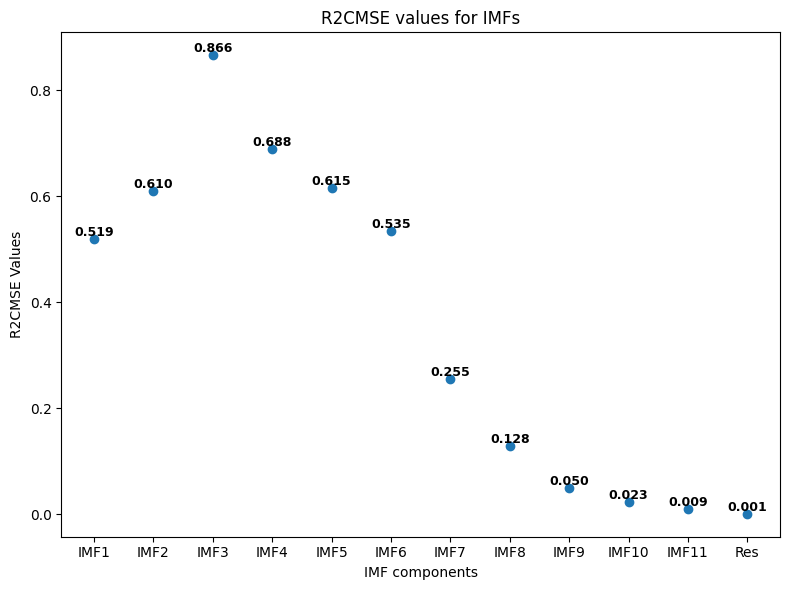

In [4]:
#Fujian dataset
import matplotlib.pyplot as plt
#TVFEMD
#x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','IMF12','IMF13','Res']
#y = [0.2941932426488651, 0.4811190704671143, 0.5031439168072264, 0.643320272369159, 0.6178082635524513, 0.6562927866576244, 0.6021571777440984, 0.5953036281705653, 0.6066973953611912, 0.6108192435848091, 0.5384361171474391, 0.537893214931095, 0.49175621892778704, 0.20275346476618353]
#WT
#x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','Res']
#y =[0.03103446908596423, 0.07864759007701673, 0.15546682644666518, 0.27782265176568754, 0.443107529612913, 0.5913125497181745, 0.7005004036713423, 0.7751592209542858, 0.5725916445443033, 0.2826456407087229, 0.006837348646685774]
#VMD
#x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','Res']
#y = [0.05131993120881324, 0.24269636364182717, 0.5178836564159346, 0.6020658104256013, 0.5797593123568193, 0.6012989984608547, 0.5837203283314564, 0.512583783326154, 0.4366079473846903, 0.40216817578824515, 0.20112040818548052, 0.12909246590841994]
#EMD
x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','Res']
y = [0.5186190901546025, 0.6095091605091645, 0.8656929737133856, 0.6880817677288262, 0.6149674612961255, 0.5349274241659843, 0.2554552283416495, 0.12776242904316584, 0.049760929346801326, 0.023205164140334078, 0.00920415476249319, 0.0005976822947434586]
plt.figure(figsize=(8, 6)) 
plt.scatter(x, y)

for i, txt in enumerate(y):
    plt.text(x[i], y[i], f'{txt:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('R2CMSE values for IMFs')
plt.xlabel('IMF components')
plt.ylabel('R2CMSE Values')

#plt.savefig('R2CMSE_fujian.png',dpi=400)

plt.tight_layout()
plt.show()

ValueError: x and y must be the same size

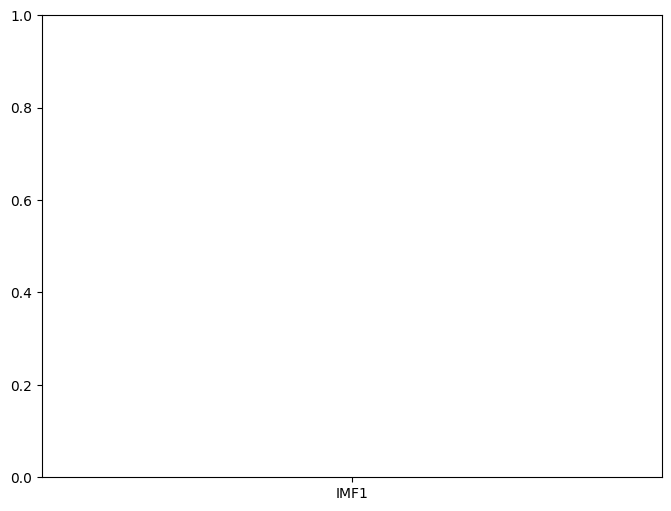

In [4]:
#Tennet dataset
import matplotlib.pyplot as plt
#TVFEMD
#x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','IMF12','IMF13','IMF14','Res']
#y = [0.4821560942085989, 0.6402284329091965, 0.662740299762401, 0.6604919439301469, 0.5805394294416529, 0.581003403265417, 0.5882075471013368, 0.511569690912237, 0.5129563323950616, 0.508544362815819, 0.4219276345846153, 0.3032622159178488, 0.24226510400755843, 0.20330904810060332, 0.06836622504081398]
#WT
#x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','Res']
#y =[0.015279273896654042, 0.03952372272184422, 0.07704016222635925, 0.16890843593141933, 0.30372336045800885, 0.4375319358239851, 0.503814209746067, 0.5692215640344119, 0.6229697928689575, 0.5927944308920715, 0.29551031296015223, 0.002139350438456574]
#VMD
#x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','IMF12','IMF13','IMF14','IMF15','IMF16','Res']
#y = [0.16763655108374123, 0.26008524716704934, 0.38274128367004884, 0.3639266923190689, 0.4518680635230546, 0.3551455263531339, 0.33009372455336644, 0.3641686471935959, 0.3970436831422454, 0.4616398954822645, 0.5204728473750302, 0.5558098466210579, 0.5642712269375789, 0.540027347740437, 0.4702886363947036, 0.21042639275878844, 0.03827788498905557]
#EMD
x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','IMF12','IMF13','Res']
y = [0.500566795004456, 0.5071793817988044, 0.44352985080872576, 0.4405311742395561, 0.5671546904148357, 0.5122510790800258, 0.4174833581801541, 0.20893721471738852, 0.09126017833212424, 0.03753210723261377, 0.015031603773694254, 0.005542556905079114, 0.0012750159029232039, 3.184142463270208e-05]
plt.figure(figsize=(8, 6)) 
plt.scatter(x, y)

for i, txt in enumerate(y):
    plt.text(x[i], y[i], f'{txt:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('R2CMSE values for IMFs')
plt.xlabel('IMF components')
plt.ylabel('R2CMSE Values')

#plt.savefig('R2CMSE.png',dpi=400)

plt.tight_layout()
plt.show()

# 5.2 SE and FE reuslts

In [1]:
!pip install EntropyHub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 3.7 MB/s eta 0:00:00


In [2]:
from line_profiler import LineProfiler
from EntropyHub import SampEn, FuzzEn

In [3]:
import pandas as pd
de=pd.read_csv('C:/Users/ym_ya/Desktop/windpower/Simulation code and data/trmg/tvfemdresults_TenneT.csv').values

# SE

In [4]:
lp = LineProfiler()
def calculate_sampen_entropyhub(data, m=2, r=0.15):

    result = SampEn(data, m=m, r=r)
    return result[0][-1]

In [5]:
def run_sampen_analysis():
    r = 0.15
    m = 2
    results_sampen = []
    
    for i in range(de.shape[1]):

        column_data = de[:, i]

        sampen_value = calculate_sampen_entropyhub(column_data, m=2, r=r)
        results_sampen.append(sampen_value)
        
    print(f"SampEn: {results_sampen}")
    return results_sampen

lp_wrapper = lp.add_function(calculate_sampen_entropyhub)
lp_wrapper = lp(run_sampen_analysis)
lp_wrapper()

lp.print_stats()

样本熵(SampEn)值: [2.767508271007362, 3.3956790389237086, 3.156747096259588, 3.1580636854714434, 2.3425747412102043, 2.13000318549765, 1.8148551840227043, 1.3938415667552735, 1.127753423575609, 1.0353942166750423, 0.7350095259208572, 0.735429901719323, 0.7598385550586176, 0.726984995341504, 0.7537718023763802]
Timer unit: 1e-09 s

Total time: 493.297 s
File: /tmp/ipykernel_47/2776416531.py
Function: calculate_sampen_entropyhub at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def calculate_sampen_entropyhub(data, m=2, r=0.15, n=2):
     3                                               """
     4                                               使用EntropyHub计算模糊熵
     5                                               
     6                                               参数:
     7                                                   data: 时间序列数据
     8                                                   m: 嵌入维度
     9             

# FE

In [13]:
def calculate_fuzzen_entropyhub(data, m=2, r=0.2, n=2):

    result = FuzzEn(data, m=m, r=r, n=n)
    return result[0][-1]

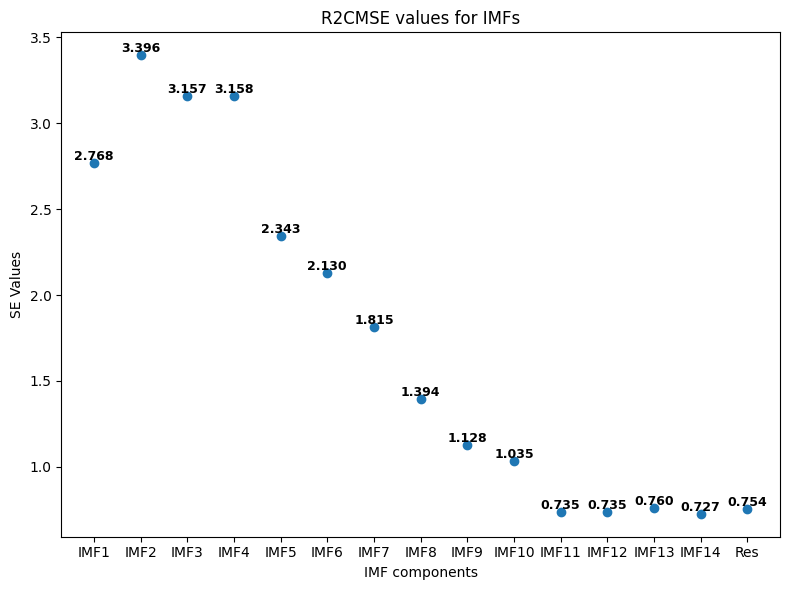

In [6]:
import matplotlib.pyplot as plt
#SE
x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','IMF12','IMF13','IMF14','Res']
y = [2.767508271007362, 3.3956790389237086, 3.156747096259588, 3.1580636854714434, 2.3425747412102043, 2.13000318549765, 1.8148551840227043, 1.3938415667552735, 1.127753423575609, 1.0353942166750423, 0.7350095259208572, 0.735429901719323, 0.7598385550586176, 0.726984995341504, 0.7537718023763802]
#FE
#x = ['IMF1', 'IMF2', 'IMF3', 'IMF4','IMF5', 'IMF6', 'IMF7', 'IMF8','IMF9', 'IMF10','IMF11','Res']
#y =[0.015279273896654042, 0.03952372272184422, 0.07704016222635925, 0.16890843593141933, 0.30372336045800885, 0.4375319358239851, 0.503814209746067, 0.5692215640344119, 0.6229697928689575, 0.5927944308920715, 0.29551031296015223, 0.002139350438456574]


plt.figure(figsize=(8, 6)) 
plt.scatter(x, y)

for i, txt in enumerate(y):
    plt.text(x[i], y[i], f'{txt:.3f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title('R2CMSE values for IMFs')
plt.xlabel('IMF components')
plt.ylabel('SE Values')

plt.tight_layout()
plt.show()